In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import tqdm
import theano.tensor as T
from pandas.plotting import autocorrelation_plot

plt.style.use('bmh')
%matplotlib inline

# Question 1

In [2]:
x = np.array([0.92, 0.42, 3.62, 0.89, -0.69, 0.45, -0.11, -0.14, -0.47, 1.09, -0.34, 0.62, 0.27])
y = np.array([0.26, 1.65, 2.10, 0.62, -1.16, 1.29, -0.82, -0.36, -0.29, 0.86, 0.19, 1.25, 0.33])
xy = np.vstack((x,y))

## Part A

The multivariate function for two standard normals with correlation $\rho$, which lies on $[0, 1]$:

$$L(x_i,x_i\;|\; \rho ) = \prod_i^n \Big(2\pi \sqrt{1 - \rho^2}\Big)^{-1}\exp{\frac{1-}{2(1 - \rho^2)}\Big[x_i^2 - 2\rho x_iy_i  + y_i^2\Big]}$$

$$\propto = \sum^i_m \Big(\sqrt{1 - \rho^2}\Big)^{-n}\exp{\frac{-1}{2(1 - \rho^2)}\Big[\sum^n_i x_i^2 - 2\rho x_iy_i  + y_i^2\Big]}$$

In [3]:
def llike(value, data):
    """Compute the likelihood for the multivariate normal
    """
    cov = np.eye(2)
    cov[[0,1], [1,0]] = value
    likelihood = stats.multivariate_normal(mean=[0,0], cov=cov).pdf(data.T).prod()
    return likelihood

obs = 100
liks = np.zeros(obs)
testVals = np.linspace(0.001, .999, obs)
for i, val in enumerate(testVals):
    liks[i] = llike(val, xy)
plt.fill_between(testVals,0, liks)
plt.title(r'Likelihood of $\rho$', fontsize=18)
plt.xlabel(r'$\rho$', fontsize=16);

## Part B

The distribution is symmetrical because the proposal density is implictly measuring the distance between the current and proposed point. Since distance is agostic to the initial point, the density is symmetric. If the points are futher then 0.2 from each other it is rejected, i.e. $|v - |$ > 0, then $q(u,v) = q(v,u) = 0$. This property also exists at the edges, where $\rho > .8$ or $< 0.2$ since the distribution is wrapped backwards to be be $[0, 0.2]$ and $[0.8, 1]$

## Part C

In [4]:
def proposal_dist(value):
    """Draw a sample from the proposal distribution
    """
    pStar = np.random.uniform(value - 0.2, value + 0.2)
    if pStar < 0:
        pStar = abs(pStar)
    if pStar > 1:
        pStar = 2 - pStar

    return pStar

In [6]:
# MCMC Metroplis Sampling Algorithm
samples = 50000
acp_rate = 0
pValues = np.zeros(samples)
pCurrent = stats.uniform.rvs() # Random draw to start

for i in tqdm.trange(samples):
    pProposed = proposal_dist(pCurrent)
    p_acp = min(1, llike(pProposed, xy) / llike(pCurrent, xy))
    accept = np.random.rand() < p_acp
    if accept:
        acp_rate += 1
        pCurrent = pProposed
    pValues[i] = pCurrent
acp_rate /= float(samples)

100%|██████████| 50000/50000 [00:38<00:00, 1313.61it/s]


In [7]:
burnedValues = pValues[5000::15]
postMean = burnedValues.mean()
postMode = stats.mode(burnedValues.round(2))[0][0]
print('Acceptance Rate: {:.4f}'.format(acp_rate))
print('Posterior Mean: {:.4f}'.format(postMean))
print('Posterior Mode: {}'.format(postMode))

Acceptance Rate: 0.6433
Posterior Mean: 0.6816
Posterior Mode: 0.77


In [8]:
len(burnedValues)

3000

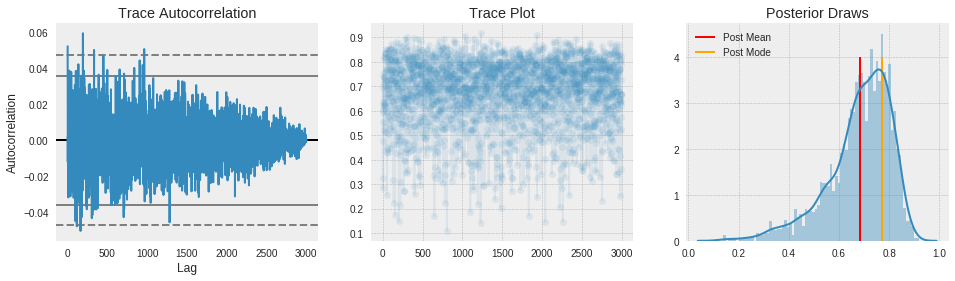

In [9]:
plt.figure(figsize=(16, 4))
_ = plt.subplot(131)
autocorrelation_plot(burnedValues, ax=_)
# plt.ylim([-.25, .25])
plt.title('Trace Autocorrelation')
plt.subplot(132).plot(burnedValues, '-o', alpha=0.1)
plt.title('Trace Plot')
ax = plt.subplot(133)
sns.distplot(burnedValues, ax=ax, bins=80)
plt.subplot(133).vlines(postMean, 0, 4, color='red', label='Post Mean')
plt.subplot(133).vlines(postMode, 0, 4, color='orange', label='Post Mode')
plt.legend()
plt.title('Posterior Draws');

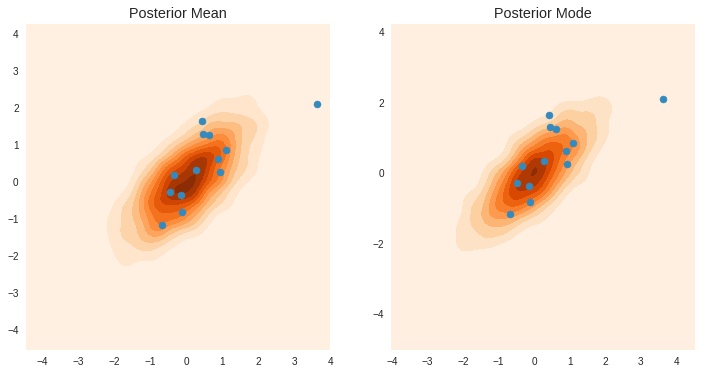

In [10]:
# Didn't do PDF out of programming ease
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
cov = np.eye(2)
cov[[0,1], [1,0]] = burnedValues.mean()
draws = stats.multivariate_normal(mean=[0,0], cov=cov).rvs(5000)
sns.kdeplot(draws, shade=True, cmap='Oranges',ax=ax1)
ax1.scatter(x, y, label='Data')
ax1.set_title('Posterior Mean')

cov = np.eye(2)
cov[[0,1], [1,0]] = .746 # the mode (could'nt do 1.0 for some reason)
draws = stats.multivariate_normal(mean=[0,0], cov=cov).rvs(5000)
sns.kdeplot(draws, shade=True, cmap='Oranges',ax=ax2)
ax2.scatter(x, y, label='Data')
ax2.set_title('Posterior Mode');

# Question 2

## Part A

$$P(\theta, \delta) = P(\theta \;| \; \delta)P(\delta)$$

$$P(\theta) = \sum_{\delta} P(\theta \; | \; \delta) P(\delta) = 0.45 f_1(\theta) + 0.1 f_2(\theta) + 0.45 f_3(\theta)$$

$$\text{where}\; f_{\delta} \;\text{is defined as follows}$$

$$f_{\delta}(\theta) = (2\pi \sigma_{\delta}^2)^{\frac{-1}{2}}\exp \Big[\frac{(\theta - \mu_{\delta})^2}{2\sigma_{\delta}^2}\Big]$$

In [11]:
var = 1./3
std = np.sqrt(var)

In [12]:
n1 = stats.norm(3, std)
n2 = stats.norm(0, std)
n3 = stats.norm(-3, std)

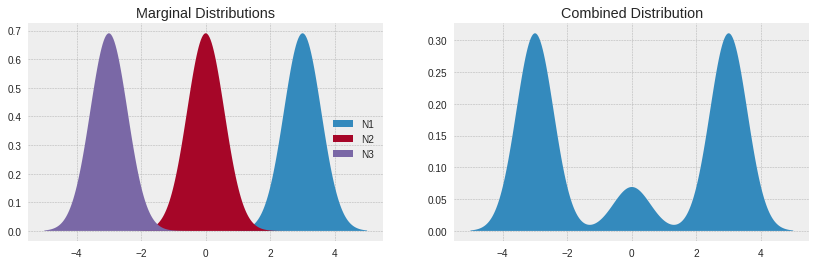

In [13]:
plt.figure(figsize=(14,4))
x = np.linspace(-5, 5, 300)
plt.subplot(121).fill_between(x, 0, n1.pdf(x), label='N1')
plt.subplot(121).fill_between(x, 0, n2.pdf(x), label='N2')
plt.subplot(121).fill_between(x,0,  n3.pdf(x), label='N3')
plt.title('Marginal Distributions')
plt.legend(bbox_to_anchor=(1, 0.6))

dist = 0.45 * n1.pdf(x) + 0.1 * n2.pdf(x) + 0.45 * n3.pdf(x)
plt.subplot(122).fill_between(x,0, dist)
plt.title('Combined Distribution');

## Part B

The full conditional distribution is:

$$Pr(\delta = k | \theta) = \frac{\exp \Big[\frac{(\theta - \mu_{k})^2}{2\sigma_{k}^2}\Big]P(\delta = k)}{\sum_j^3 \exp \Big[\frac{(\theta - \mu_{j})^2}{2\sigma_{\delta}^2}\Big]P(\delta = j)}$$  

In [14]:
def conditional_dist(value):
    
    prob1 = 0.45 * n1.pdf(value)
    prob2 = 0.1 * n2.pdf(value)
    prob3 = 0.45 * n3.pdf(value)
    
    probs = np.array([prob1, prob2, prob3])
    probs /= probs.sum()
    
    return probs

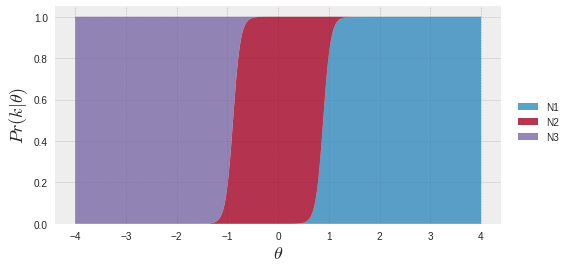

In [15]:
def main():
    obs = 300
    space = np.linspace(-4, 4, obs)
    condProbs = np.array(map(conditional_dist, np.linspace(-6, 6, obs)))

    plt.figure(figsize=(8, 4))
    plt.stackplot(space, condProbs[:, 0], condProbs[:, 1], condProbs[:, 2], alpha=0.8, labels=['N1', 'N2', 'N3'])
    plt.xlabel(r'$\theta$', fontsize=18)
    plt.ylabel(r'$Pr(k|\theta)$', fontsize=18)
    plt.title
    plt.legend(bbox_to_anchor=(1.15, 0.6));
main()

## PART C

In [16]:
def main(samples):
    
    initDelta = 2
    initTheta = 0
    
    mixtureParams = dict({1:3, 2:0, 3:-3})
    
    deltaSamples = [initDelta]
    thetaSamples = [initTheta]
        
    for i in tqdm.trange(samples):
        delta_curr = np.argmax(conditional_dist(thetaSamples[-1])) + 1
        deltaSamples.append(delta_curr)
        mu = mixtureParams[deltaSamples[-1]]
        theta_curr = stats.norm(mu, std).rvs()
        thetaSamples.append(theta_curr)
        
    return deltaSamples, thetaSamples    

In [17]:
delta1000, theta1000 = main(1000)

100%|██████████| 1000/1000 [00:01<00:00, 623.94it/s]


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


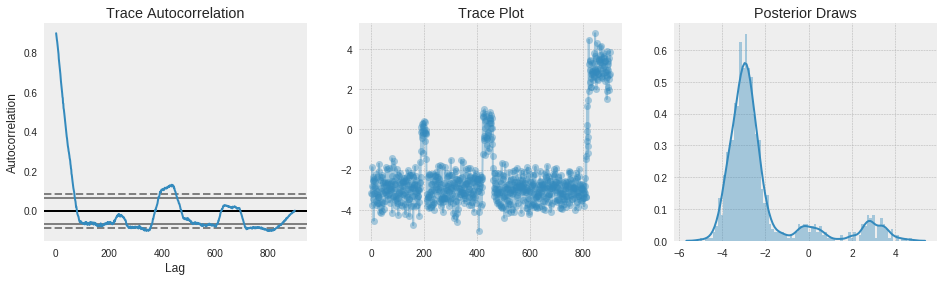

In [18]:
burnedValues = theta1000[100:]
plt.figure(figsize=(16, 4))
_ = plt.subplot(131)
autocorrelation_plot(burnedValues, ax=_)
# plt.ylim([-.25, .25])
plt.title('Trace Autocorrelation')
plt.subplot(132).plot(burnedValues, '-o', alpha=0.4)
plt.title('Trace Plot')
ax = plt.subplot(133)
sns.distplot(burnedValues, ax=ax, bins=80)
plt.legend()
plt.title('Posterior Draws');

In [19]:
delta20000, theta20000 = main(20000)

100%|██████████| 20000/20000 [00:33<00:00, 594.84it/s]


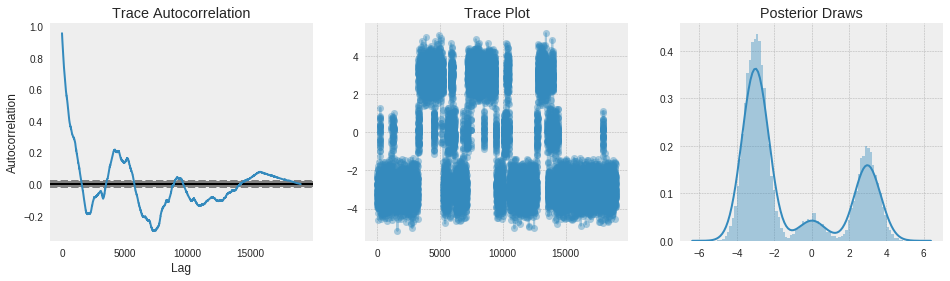

In [20]:
burnedValues = theta20000[1000:]
plt.figure(figsize=(16, 4))
_ = plt.subplot(131)
autocorrelation_plot(burnedValues, ax=_)
# plt.ylim([-.25, .25])
plt.title('Trace Autocorrelation')
plt.subplot(132).plot(burnedValues, '-o', alpha=0.4)
plt.title('Trace Plot')
ax = plt.subplot(133)
sns.distplot(burnedValues, ax=ax, bins=80)
plt.legend()
plt.title('Posterior Draws');

# Question 3

The posterior mean of $\beta_1$ for drug dosage level 4 is $.654$ and the variance is $0.02187$. The 95% HPD is $\big( 0.371, .947 \big)$. The posterior portion for drug dosage 4, $\hat p_4$, is $0.404$

In [21]:
data = pd.DataFrame([list(range(1,6)), [3,3,3,6,3], [0,0,0,3,2]], index=['d', 'n', 'x'])

In [22]:
data

,0,1,2,3,4
d,1,2,3,4,5
n,3,3,3,6,3
x,0,0,0,3,2


In [23]:
data = data.values.astype(float)
d = data[0]
n = data[1]
x = data[2]

In [24]:
def invlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as model:
    # Model setup
    b1 = pm.Normal('beta1', mu=0, sd=2)
    b0 = -3.
    mu = b0 + d * b1
    p = invlogit(mu)
    y_hat = pm.Binomial('outcome', p=p, n=n, observed=x)
    
    # Sampling
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(50000, step=step, start=start) 

/usr/local/lib/python2.7/dist-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 5.502619
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


100%|██████████| 50000/50000 [00:05<00:00, 8675.91it/s]


In [25]:
burned_trace = trace[8000::9]
len(burned_trace)

4667

In [26]:
burned_trace['beta1'].var()

0.022811055672855251

Posterior Variance: 0.02281


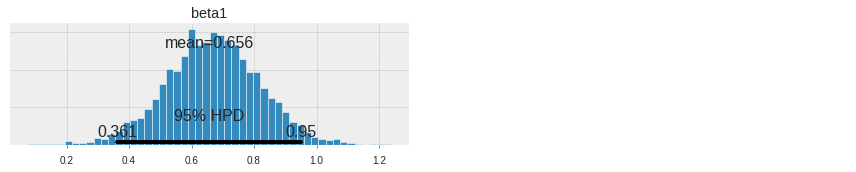

In [27]:
_ = pm.plot_posterior(burned_trace, bins=50)
print("Posterior Variance: {:.5f}".format(burned_trace['beta1'].var()))

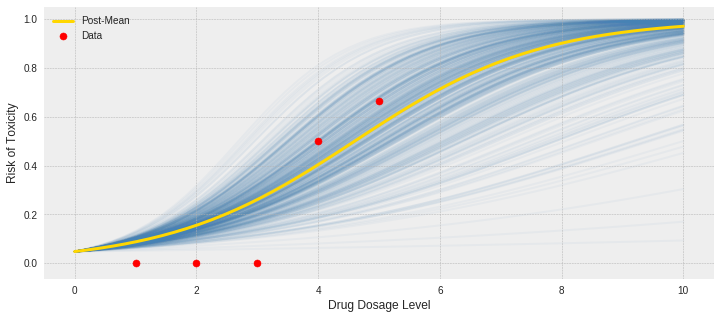

In [28]:
f = lambda a, b, xp: np.exp(a + b*xp)/(1 + np.exp(a + b*xp))  # Numpy version of invlogit

xp = np.linspace(0, 10, 50)[:, None]  # sample values
a = -3.
b = burned_trace['beta1'][::10, None].T  # Posterior values
mu = b.mean(axis=1)
plt.figure(figsize=(12, 5))
plt.plot(xp, f(a, b, xp), color='steelblue', alpha=0.05, zorder=0)
plt.plot(xp, f(a, mu, xp), color='gold', label='Post-Mean', lw=3, zorder=1)
plt.scatter(d, x/n, s=50, color='r', label='Data', zorder=2)
plt.xlabel('Drug Dosage Level')
plt.ylabel('Risk of Toxicity')
plt.legend();

In [29]:
post_beta1 = burned_trace['beta1'].mean()
post_beta0 = -3.
postmu = post_beta1 * 4 + post_beta0
postP = invlogit(postmu)
print("Posterior Estimate: {:4f}".format(float(postP.eval())))

Posterior Estimate: 0.406984
